# Age Estimation on IMDB-WIKI Dataset

In [192]:
import torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch import optim
import time

from utils.img_to_vec import Img2Vec
import os

batch_size = 32
nb_categories = 101



In [84]:
AZURE_MACHINE = False
COLAB_MACHINE = False
LOCAL_MACHINE = True

if LOCAL_MACHINE:
    data_root = '/home/dongwenjian/Jupyter/DeepLearningWithPyTorch/projet/data5/'

    train_set_dir = data_root + 'wiki_crop_train/'
    val_set_dir = data_root + 'wiki_crop_val/'
    test_set_dir = data_root + 'wiki_crop_test/'

    result_dir = '/home/dongwenjian/Jupyter/DeepLearningWithPyTorch/projet/results/'
    
if AZURE_MACHINE:
    data_root = '/home/wenjian/data5/'

    train_set_dir = data_root + 'wiki_crop_train/'
    val_set_dir = data_root + 'wiki_crop_val/'
    test_set_dir = data_root + 'wiki_crop_test/'

    result_dir = '/home/wenjian/results/'
    
if COLAB_MACHINE:
    pass

Data preparation and augmentation for the network

In [224]:
def get_features(pil_image):
    fe = Img2Vec(cuda=False)  # change this if you use Cuda version of the PyTorch.
    #img = Image.open(image_path)
    
    # The model could only handle 3-channel images, so we convert 1-channel image to 3-channel image
    channels = pil_image.split()
    if len(channels) == 1:
        pil_image = Image.merge('RGB', (channels[0], channels[0], channels[0]))
    pil_image = pil_image.resize((224, 224))
    features = fe.get_vec(pil_image).reshape(1, -1)
    return features.squeeze()

In [225]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.Lambda(lambda image: get_features(image)),
    #transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) # Imagenet standards

val_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.Lambda(lambda image: get_features(image)),
    #transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]) # Imagenet standards

# What should we do for test??????
test_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),  # Image net standards
    transforms.ToTensor()])



Set up data loaders

In [163]:
train_set = ImageFolder(train_set_dir, transform=train_transform, target_transform=None)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = ImageFolder(val_set_dir, transform=val_transform, target_transform=None)
val_loader = DataLoader(val_set, batch_size=batch_size)

test_set = ImageFolder(test_set_dir, transform=test_transform, target_transform=None)
test_loader = DataLoader(test_set, batch_size=batch_size)

Input size of the image 224\*224\* 3

In [164]:
class twoHiddenNet(nn.Module):

    def __init__(self, input_unit_size=512, hidden_layer1_size=256, hidden_layer2_size=128, output_layer_size=1):
        super(twoHiddenNet, self).__init__()
        self.layer1    = nn.Linear(input_unit_size, hidden_layer1_size)
        nn.init.xavier_uniform(self.layer1.weight)

        self.layer2    = nn.Linear(hidden_layer1_size, hidden_layer2_size)
        nn.init.xavier_uniform(self.layer2.weight)

        self.layer3    = nn.Linear(hidden_layer2_size, output_layer_size)
        nn.init.xavier_uniform(self.layer3.weight)


    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = self.layer3(x)
        return x

The custom cross entropy loss for smoothed target

Choose the model as well as curresponding loss function and optimizer

In [165]:
model = twoHiddenNet(input_unit_size = 512,
                             hidden_layer1_size = 256,
                             hidden_layer2_size = 128,
                             output_layer_size  = 1
                             )
LR = 1e-4
REG = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop( model.parameters(), lr=LR, weight_decay=REG)

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if __name__ == '__main__':
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':


In [166]:
def train(model, train_loader, criterion, optimizer, epoch):
    print('Start training...')
    model.train()
    log_interval = 10
    losses = []
    with open(result_dir + 'training_log.txt', 'a') as f: 
        for batch_idx, (data, labels) in enumerate(train_loader):
            #data = data.squeeze()
            #print('data.shape', data.shape)
            #print('label.shape', labels.shape)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, labels.float())
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                f.write('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
    return losses

In [167]:
def validate(model, val_loader):
    print("Start validation...")
    model.eval()
    test_loss = 0.0
    diff = 0.0
    print('---val_loader size--- ', len(val_loader.dataset))
    with torch.no_grad():
        for data, target in val_loader:            
            out = model(data)
            test_loss += criterion(out, target.float()).item()
            diff += nn.functional.l1_loss(out.float(), target.float(), size_average=True) #nn.functional.l1_loss output the average l1 distance by default
            
    test_loss /= len(val_loader.dataset)
    diff /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, average diff: {}\n'.format(test_loss, diff))
    with open(result_dir + 'validation_log.txt', 'a') as f:
        f.write('\nValidation set: Average loss: {:.4f}, average diff: {}\n'.format(test_loss, diff))
    return test_loss, diff


In [168]:
import numpy as np


n_epochs = 10
train_losses_all = []
val_loss_all = []
val_diff_all = []
for epoch in range(n_epochs):
    print(epoch,'th epoch started...')
    epoch_start = time.time()
    train_losses = train(model, train_loader, criterion, optimizer, epoch)
    train_losses_all.append(train_losses)
    val_loss, diff = validate(model, val_loader)
    val_loss_all.append(val_loss)
    val_diff_all.append(diff)
    torch.save(model.state_dict(),"model_trained_" + str(epoch) + ".pt")

    train_loss_array = np.array(train_losses_all)
    val_loss_array = np.array(val_loss_all)
    val_diff_array = np.array(val_diff_all)

    np.save(result_dir + 'train_loss_array.npy', train_loss_array)
    np.save(result_dir + 'val_loss_array.npy', val_loss_array)
    np.save(result_dir + 'val_diff_array.npy', val_diff_array)
    
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    print(epoch, 'th epoch time: ', epoch_time)

0 th epoch started...
Start training...


/home/dongwenjian/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Train Epoch: 0 [0/4138 (0%)]	Loss: 3769.248779
Train Epoch: 0 [320/4138 (8%)]	Loss: 1519.233643
Train Epoch: 0 [640/4138 (15%)]	Loss: 664.196106
Train Epoch: 0 [960/4138 (23%)]	Loss: 829.726196
Train Epoch: 0 [1280/4138 (31%)]	Loss: 677.768860
Train Epoch: 0 [1600/4138 (38%)]	Loss: 717.591980
Train Epoch: 0 [1920/4138 (46%)]	Loss: 821.677429
Train Epoch: 0 [2240/4138 (54%)]	Loss: 676.848206
Train Epoch: 0 [2560/4138 (62%)]	Loss: 612.802917
Train Epoch: 0 [2880/4138 (69%)]	Loss: 797.247681
Train Epoch: 0 [3200/4138 (77%)]	Loss: 735.028381
Train Epoch: 0 [3520/4138 (85%)]	Loss: 662.728149
Train Epoch: 0 [3840/4138 (92%)]	Loss: 640.835754
Start validation...
---val_loader size---  719


/home/dongwenjian/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Validation set: Average loss: 21.0817, average diff: 0.6979995965957642

0 th epoch time:  1883.4523680210114
1 th epoch started...
Start training...
Train Epoch: 1 [0/4138 (0%)]	Loss: 568.108093
Train Epoch: 1 [320/4138 (8%)]	Loss: 894.224976
Train Epoch: 1 [640/4138 (15%)]	Loss: 668.568237
Train Epoch: 1 [960/4138 (23%)]	Loss: 721.146851
Train Epoch: 1 [1280/4138 (31%)]	Loss: 788.844055
Train Epoch: 1 [1600/4138 (38%)]	Loss: 538.526917
Train Epoch: 1 [1920/4138 (46%)]	Loss: 708.302673
Train Epoch: 1 [2240/4138 (54%)]	Loss: 922.394348
Train Epoch: 1 [2560/4138 (62%)]	Loss: 527.447327
Train Epoch: 1 [2880/4138 (69%)]	Loss: 931.266418
Train Epoch: 1 [3200/4138 (77%)]	Loss: 658.261169
Train Epoch: 1 [3520/4138 (85%)]	Loss: 768.681152
Train Epoch: 1 [3840/4138 (92%)]	Loss: 787.833801
Start validation...
---val_loader size---  719

Validation set: Average loss: 20.2674, average diff: 0.684137225151062

1 th epoch time:  1880.8991136550903
2 th epoch started...
Start training...
Train Epoc

In [119]:
# Just for test validate function
val_loss, diff = validate(model, val_loader)

Start validation...
---val_loader size---  719


/home/dongwenjian/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/home/dongwenjian/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Validation set: Average loss: 69.3337, average diff: 1.268880009651184



In [100]:
from PIL import Image

In [226]:
def predict_based_on_img2vec(model, img_path):
    img = Image.open(img_path)
    #img = torchvision.transforms.functional.to_tensor(img)
    #img = torchvision.transforms.functional.to_pil_image(img)
    #img = torchvision.transforms.functional.resize(img, 256)
    #five_imgs = torchvision.transforms.functional.five_crop(img, size=224)
    #img = five_imgs[4] # Center crop
    features = get_features(img)
    #print('---aaa---', features.shape)
    batch_features = np.reshape(features, (1, features.shape[0]))
    #print('---bbb---', batch_features.shape)
    with torch.no_grad():
        out = model(torch.tensor(batch_features))
        #print(out.item())
    return out.item()

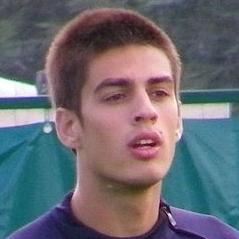

In [227]:
from IPython.display import Image as IPyImage
img_name = data_root + 'wiki_crop_test/20/23655297_1990-07-01_2010.jpg'
IPyImage(filename=img_name)

In [228]:
predict_based_on_img2vec(model, img_name)

/home/dongwenjian/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


49.144371032714844

In [229]:
def parse_age(image_name):
    '''
    example: 23300_1962-06-19_2011.jpg
    the calculation: age=2011-1962=49
    return 49
    '''
    tokens1 = image_name.split('.')
    tokens2 = tokens1[0].split('_')
    tokens3 = tokens2[1].split('-')
    dob = int(tokens3[0])
    photo = int(tokens2[2])
    return photo-dob

In [230]:
def test(model, test_data_path):
    diffs_by_age = {}
    folders = os.listdir(test_data_path)
    for folder in folders:
        images = os.listdir(test_data_path+folder)
        print('working on folder ', folder, ', ', len(images), ' images to be tested')
        for image in images:
            try:
                
                age_est = predict_based_on_img2vec(model, test_data_path+folder+'/'+image)
                age_ref = parse_age(image)
                if not age_ref in diffs_by_age:
                    diffs_by_age[age_ref] = []
                dif = abs(age_est - age_ref)
                diffs_by_age[age_ref].append(dif)
            except Exception as e:
                print('Exception caught on path ', folder+'/'+image)
                raise e
    return diffs_by_age

In [231]:
diffs_by_age = test(model, '/home/dongwenjian/Jupyter/DeepLearningWithPyTorch/projet/data2/wiki_crop_test/')

working on folder  69 ,  14  images to be tested


/home/dongwenjian/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


working on folder  27 ,  89  images to be tested
working on folder  41 ,  46  images to be tested
working on folder  62 ,  19  images to be tested
working on folder  50 ,  18  images to be tested
working on folder  73 ,  6  images to be tested
working on folder  71 ,  12  images to be tested
working on folder  74 ,  3  images to be tested
working on folder  47 ,  29  images to be tested
working on folder  39 ,  27  images to be tested
working on folder  91 ,  5  images to be tested
working on folder  29 ,  85  images to be tested
working on folder  100 ,  0  images to be tested
working on folder  70 ,  12  images to be tested
working on folder  66 ,  16  images to be tested
working on folder  20 ,  63  images to be tested
working on folder  7 ,  0  images to be tested
working on folder  81 ,  4  images to be tested
working on folder  54 ,  21  images to be tested
working on folder  48 ,  17  images to be tested
working on folder  40 ,  33  images to be tested
working on folder  14 ,  4

Text(0.5, 1.0, 'model tested on our test data')

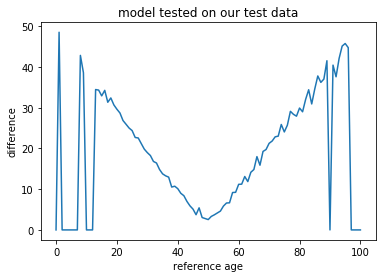

In [234]:
import matplotlib.pyplot as plt

n = 101
diffs = np.zeros((n,))
for key in diffs_by_age:
    diffs[key] = np.mean(diffs_by_age[key])

plt.plot(diffs)
plt.xlabel('reference age')
plt.ylabel('difference')
plt.title('model tested on our test data')

In [45]:
a = torch.tensor([1,2,3])
b = torch.tensor([1.1, 2.5, 3.3])

In [46]:
nn.functional.l1_loss(a.float() ,b)

tensor(0.3000)

In [211]:
img_name = '/home/dongwenjian/Jupyter/DeepLearningWithPyTorch/projet/data2/wiki_crop_test/27/3265699_1952-01-23_1979.jpg'
pil_image = Image.open(img_name)
channels = pil_image.split()


In [212]:
len(channels)

1

In [221]:
channels

(<PIL.Image.Image image mode=L size=398x397 at 0x7F231711CFD0>,)

In [213]:
if len(channels) == 1:
    new_img = Image.merge('RGB', (channels[0], channels[0], channels[0]))

In [216]:
new_channels = new_img.split()
new_channels

(<PIL.Image.Image image mode=L size=398x397 at 0x7F2316F126D8>,
 <PIL.Image.Image image mode=L size=398x397 at 0x7F2316F12B70>,
 <PIL.Image.Image image mode=L size=398x397 at 0x7F2316F121D0>)

In [222]:
a = (1,)

In [223]:
len(a)

1